# Supply Chain Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import torch
import lropt
import sys
import torch.nn.functional as f
sys.path.append('..')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

In [2]:
ETFS = ['AGG', 'VTI', 'VNQ', 'XLF', 'XLV', 'XLY', 'XLP', 'XLU', 'XLI', 'XLE', 'IBB', 'ITA']
N_ASSETS = len(ETFS)
HZN = 24
VAL = 2443
TEST = VAL * 3
KAPPA = np.full(N_ASSETS, 0.001)
SHORT = np.full(N_ASSETS, 0.001)
GAMMA = 15.0

M1 = torch.tensor(2.0)
M2 = torch.tensor(1.00)
len(ETFS)
MU = np.load('data/markowitz_mu.npy')
COV = np.load('data/markowitz_sigma.npy')
COV_SQRT = sc.linalg.sqrtm(COV)

mulog = torch.tensor(np.load('data/markowitz_mu_log.npy'))
covlog = torch.tensor(np.load('data/markowitz_cov_log.npy'))

In [3]:
def init_holdings(cov_sqrt, mu, gamma):
    N = N_ASSETS
    ht = cp.Variable(N)
    risk = gamma * cp.sum_squares(cov_sqrt @ ht)
    returns = mu.T @ ht
    objective = returns - risk - SHORT.T @ cp.neg(ht)
                                                                                
    constraints = [                                                             
        cp.sum(ht) == 1,
    ]                                                                            
    problem = cp.Problem(cp.Maximize(objective), constraints)
    problem.solve()
    return ht.value

H0 = torch.tensor(init_holdings(COV_SQRT, MU, GAMMA))

In [4]:
init_size = 100
kappa_tch = torch.from_numpy(KAPPA)
logreturn1p_dist = torch.distributions.MultivariateNormal(
    mulog, covlog)

N = N_ASSETS
htall = lropt.Parameter(N+1, data= np.zeros((init_size,N+1)))   
mu = lropt.UncertainParameter(N,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1, data = np.zeros((init_size,N))))
ht = htall[:N]
                                                                            
utall = cp.Variable(N+1)
htp = cp.Variable(N) 
ut, tau = utall[:N], utall[N:]      
                                                                            
objective = tau
                                                                            
transaction_cost = KAPPA.T @ cp.abs(ut)
shorting_cost = SHORT.T @ cp.neg(htp)
constraints = [
    -mu.T @ htp <= tau,
    cp.sum(ut) + transaction_cost + shorting_cost <= 0,
    htp == ht + ut,
]                                                                            
prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
trainer = lropt.Trainer(prob)
policy = trainer.create_cvxpylayer(variables = [utall])

In [6]:
class PortSimulator(lropt.Simulator):

  def simulate(self, x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    ret = torch.exp(logreturn1p_dist.sample((batch_size,)))
    newx = ret * (x[:,:N] + u[:,:N])
    xsums = torch.sum(newx,axis=1).view((batch_size,1))
    newxnorm = newx/xsums
    x = torch.cat([newxnorm,xsums],axis=1)
    return x

  def stage_cost(self,x,u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    xval,sval = x[:,:N], x[:,N:]
    return -self.utility_fn(sval)
  
  def utility_fn(self,x, m1=M1, m2=M2):
    return (x-1)
    # return torch.min(m1*(x - 1), m2*(x - 1))

  def constraint_cost(self,x,u,alpha):
    eta = 0.05
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    xval,sval = x[:,:N], x[:,N:]
    uval, tau = u[:,:N], u[:,N:]
    cvar_term =(1/eta)*(torch.max(torch.max(-sval - tau,axis=1)[0] - alpha,torch.zeros(batch_size))[0]) + alpha
    return 0.001*(cvar_term - 0.001)

  def init_state(self,batch_size, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    H0 = torch.tensor(init_holdings(COV_SQRT, MU, GAMMA))
    ret = torch.exp(logreturn1p_dist.sample((batch_size,)))
    newH = ret*H0
    means = torch.sum(newH,axis=1).view((batch_size,1))
    newH = newH/means
    zer = torch.zeros(batch_size, 1).double()
    x_batch = torch.cat([newH,zer],axis=1)
    return x_batch
simulator = PortSimulator()

In [7]:
# Perform training
time_horizon = 24
epochs = 3000
batch_size = 5
lr = 0.001
# init_x = simulator.init_state(seed = 0, batch_size = 100)
# init_h = init_x[:,:N]
init_a = COV_SQRT
init_b = MU
val_costs1, val_costs_constr1, \
  paramvals, x_base1, u_base1 = trainer.multistage_train(simulator, 
                                                       policy = policy, 
                         time_horizon = time_horizon, epochs = epochs, 
                         batch_size = batch_size, init_eps=15, seed=0,
                          init_a = init_a, init_b = init_b,
                          optimizer = "SGD",lr= lr, momentum = 0, init_alpha = 0.0, scheduler = True, lr_gamma = 0.6, contextual = True)

Baseline cost:  -0.004555973107098491
epoch 0, valid -4.5560e-03
epoch 1, valid -4.2720e-03
epoch 2, valid -4.2800e-03
epoch 3, valid -4.5085e-03
epoch 4, valid -4.3160e-03
epoch 5, valid -4.5616e-03
epoch 6, valid -4.4320e-03
epoch 7, valid -4.3432e-03
epoch 8, valid -4.6284e-03
epoch 9, valid -4.7429e-03
epoch 10, valid -4.4829e-03
epoch 11, valid -4.8182e-03
epoch 12, valid -5.2241e-03
epoch 13, valid -5.3822e-03
epoch 14, valid -4.3828e-03
epoch 15, valid -4.5924e-03
epoch 16, valid 1.5187e-02
epoch 17, valid -5.7688e-03
epoch 18, valid -5.8352e-03
epoch 19, valid -5.5128e-03
epoch 20, valid -5.4200e-03
epoch 21, valid -5.4385e-03
epoch 22, valid -5.2479e-03
epoch 23, valid -5.1665e-03
epoch 24, valid -5.0084e-03
epoch 25, valid -5.3240e-03
epoch 26, valid -5.2812e-03
epoch 27, valid -4.8979e-03
epoch 28, valid -4.9937e-03
epoch 29, valid -4.9062e-03
epoch 30, valid -4.6682e-03
epoch 31, valid -4.5419e-03
epoch 32, valid -4.3674e-03
epoch 33, valid -4.3364e-03
epoch 34, valid -4.43

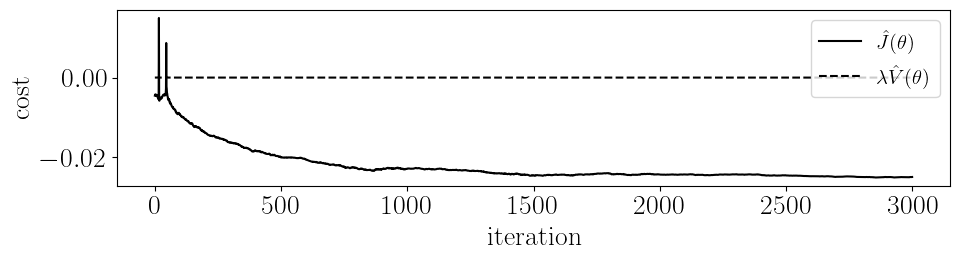

In [33]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

plt.figure(figsize=(10, 3))
plt.plot((np.array(val_costs1)), c='k', label=r"$\hat{J}(\theta)$")
plt.plot(np.array(val_costs_constr1), c = 'k', linestyle = "--", label = r"$\lambda\hat{V}(\theta)$")
# plt.ylim([-0.08,0.02])
plt.xlabel('iteration')
plt.ylabel('cost')
plt.tight_layout()
plt.legend(fontsize = 15, loc = "upper right")
plt.savefig("port_iters.pdf", bbox_inches='tight')
plt.show()

In [9]:
np.array(val_costs1)

array([-0.00455497, -0.00427102, -0.00427904, ..., -0.02506442,
       -0.02505349, -0.0250564 ])

In [12]:
(val_costs1[-1] - val_costs1[0])/val_costs1[0]

4.500888279121193

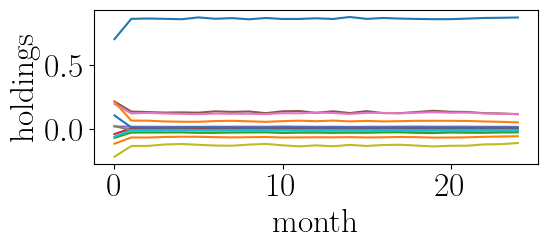

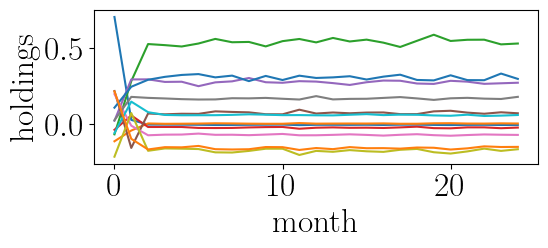

In [10]:
x_mat = torch.vstack(x_base1[0][0])
plt.figure(figsize=(6, 3))
for stock in range(N):
  plt.plot(x_mat[:,stock])
plt.xlabel('month')
plt.ylabel('holdings')
plt.tight_layout()
plt.savefig("port_holdings_init.pdf", bbox_inches='tight')
plt.show()

x_mat_fin = torch.vstack(x_base1[-1][0])
plt.figure(figsize=(6, 3))
for stock in range(N):
  plt.plot(x_mat_fin[:,stock])
plt.xlabel('month')
plt.ylabel('holdings')
plt.tight_layout()
plt.savefig("port_holdings_fin.pdf", bbox_inches='tight')
plt.show()

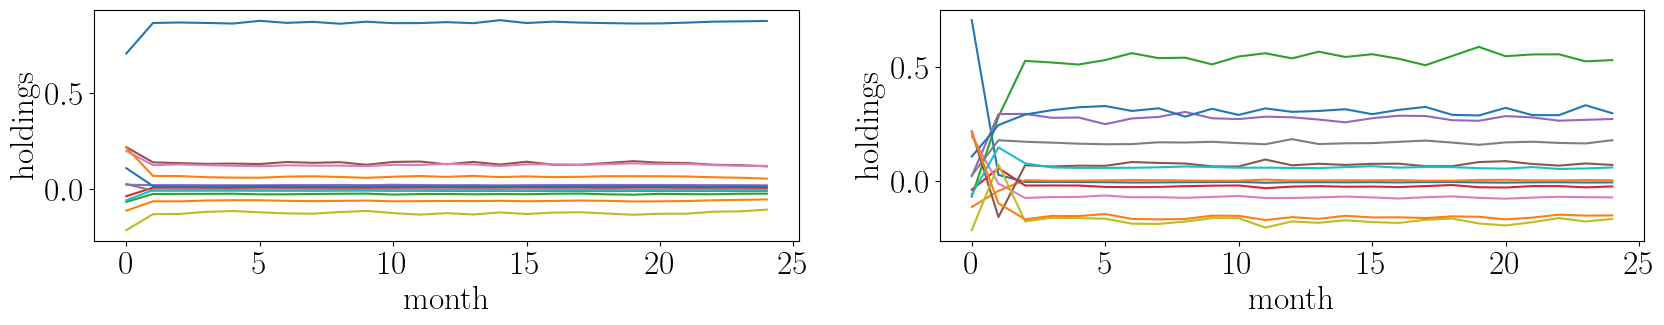

In [11]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
for stock in range(N):
  ax1.plot(x_mat[:,stock])
ax1.set_xlabel('month')
ax1.set_ylabel('holdings')

for stock in range(N):
  ax2.plot(x_mat_fin[:,stock])
ax2.set_xlabel('month')
ax2.set_ylabel('holdings')
plt.savefig("port_holdings.pdf", bbox_inches='tight')
plt.show()

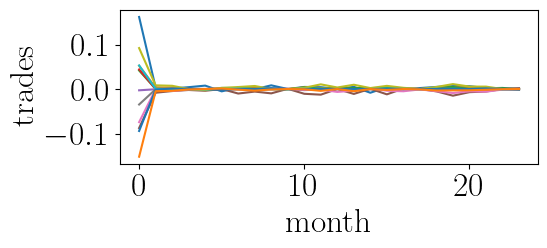

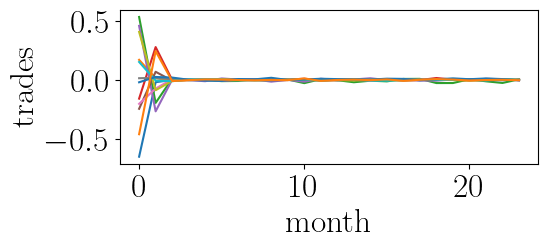

In [22]:
u_mat = torch.vstack(u_base1[0][0])
plt.figure(figsize=(6, 3))
for stock in range(N):
  plt.plot(u_mat[0:,stock])
plt.xlabel('month')
plt.ylabel('trades')
plt.tight_layout()
plt.show()

u_mat_fin = torch.vstack(u_base1[-1][0])
plt.figure(figsize=(6, 3))
for stock in range(N):
  plt.plot(u_mat_fin[0:,stock])
plt.xlabel('month')
plt.ylabel('trades')
plt.tight_layout()
plt.show()

In [23]:
ret = torch.exp(logreturn1p_dist.sample((1,)))
print((ret*H0).sum(), x_mat[1:,N:].sum()/24, x_mat_fin[1:,N:].sum()/24)

tensor(0.9911, dtype=torch.float64) tensor(1.0046, dtype=torch.float64) tensor(1.0246, dtype=torch.float64)
